In [1]:
#!/usr/bin/python
# Software License Agreement (BSD License)
#
# Copyright (c) 2013, Juergen Sturm, TUM
# All rights reserved.
#
# Redistribution and use in source and binary forms, with or without
# modification, are permitted provided that the following conditions
# are met:
#
#  * Redistributions of source code must retain the above copyright
#    notice, this list of conditions and the following disclaimer.
#  * Redistributions in binary form must reproduce the above
#    copyright notice, this list of conditions and the following
#    disclaimer in the documentation and/or other materials provided
#    with the distribution.
#  * Neither the name of TUM nor the names of its
#    contributors may be used to endorse or promote products derived
#    from this software without specific prior written permission.
#
# THIS SOFTWARE IS PROVIDED BY THE COPYRIGHT HOLDERS AND CONTRIBUTORS
# "AS IS" AND ANY EXPRESS OR IMPLIED WARRANTIES, INCLUDING, BUT NOT
# LIMITED TO, THE IMPLIED WARRANTIES OF MERCHANTABILITY AND FITNESS
# FOR A PARTICULAR PURPOSE ARE DISCLAIMED. IN NO EVENT SHALL THE
# COPYRIGHT OWNER OR CONTRIBUTORS BE LIABLE FOR ANY DIRECT, INDIRECT,
# INCIDENTAL, SPECIAL, EXEMPLARY, OR CONSEQUENTIAL DAMAGES (INCLUDING,
# BUT NOT LIMITED TO, PROCUREMENT OF SUBSTITUTE GOODS OR SERVICES;
# LOSS OF USE, DATA, OR PROFITS; OR BUSINESS INTERRUPTION) HOWEVER
# CAUSED AND ON ANY THEORY OF LIABILITY, WHETHER IN CONTRACT, STRICT
# LIABILITY, OR TORT (INCLUDING NEGLIGENCE OR OTHERWISE) ARISING IN
# ANY WAY OUT OF THE USE OF THIS SOFTWARE, EVEN IF ADVISED OF THE
# POSSIBILITY OF SUCH DAMAGE.
#
# Requirements: 
# sudo apt-get install python-argparse

"""
This script computes the absolute trajectory error from the ground truth
trajectory and the estimated trajectory.
"""

import sys
import numpy
import argparse
import associate

def align(model,data):
    """Align two trajectories using the method of Horn (closed-form).
    
    Input:
    model -- first trajectory (3xn)
    data -- second trajectory (3xn)
    
    Output:
    rot -- rotation matrix (3x3)
    trans -- translation vector (3x1)
    trans_error -- translational error per point (1xn)
    
    """
    numpy.set_printoptions(precision=3,suppress=True)
    model_zerocentered = model - model.mean(1)
    data_zerocentered = data - data.mean(1)
    
    W = numpy.zeros( (3,3) )
    for column in range(model.shape[1]):
        W += numpy.outer(model_zerocentered[:,column],data_zerocentered[:,column])
    U,d,Vh = numpy.linalg.linalg.svd(W.transpose())
    S = numpy.matrix(numpy.identity( 3 ))
    if(numpy.linalg.det(U) * numpy.linalg.det(Vh)<0):
        S[2,2] = -1
    rot = U*S*Vh
    trans = data.mean(1) - rot * model.mean(1)
    
    model_aligned = rot * model + trans
    alignment_error = model_aligned - data
    
    trans_error = numpy.sqrt(numpy.sum(numpy.multiply(alignment_error,alignment_error),0)).A[0]
        
    return rot,trans,trans_error

def plot_traj(ax,stamps,traj,style,color,label):
    """
    Plot a trajectory using matplotlib. 
    
    Input:
    ax -- the plot
    stamps -- time stamps (1xn)
    traj -- trajectory (3xn)
    style -- line style
    color -- line color
    label -- plot legend
    
    """
    stamps.sort()
    interval = numpy.median([s-t for s,t in zip(stamps[1:],stamps[:-1])])
    x = []
    y = []
    last = stamps[0]
    for i in range(len(stamps)):
        if stamps[i]-last < 2*interval:
            x.append(traj[i][0])
            y.append(traj[i][1])
        elif len(x)>0:
            ax.plot(x,y,style,color=color,label=label)
            label=""
            x=[]
            y=[]
        last= stamps[i]
    if len(x)>0:
        ax.plot(x,y,style,color=color,label=label)
            


In [2]:
import numpy as np
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
from matplotlib.patches import Ellipse
%matplotlib inline

In [3]:
def calculate_traj(first_file, second_file):
    
    first_list = associate.read_file_list(first_file)
    second_list = associate.read_file_list(second_file)


    matches = associate.associate(first_list, second_list,float(offset),float(max_difference))    
    if len(matches)<2:
        sys.exit("Couldn't find matching timestamp pairs between groundtruth and estimated trajectory! Did you choose the correct sequence?")


    first_xyz = numpy.matrix([[float(value) for value in first_list[a][0:3]] for a,b in matches]).transpose()
    second_xyz = numpy.matrix([[float(value)*float(scale) for value in second_list[b][0:3]] for a,b in matches]).transpose()
    rot,trans,trans_error = align(second_xyz,first_xyz)

    second_xyz_aligned = rot * second_xyz + trans

    first_stamps = first_list.keys()
    first_stamps.sort()
    first_xyz_full = numpy.matrix([[float(value) for value in first_list[b][0:3]] for b in first_stamps]).transpose()

    second_stamps = second_list.keys()
    second_stamps.sort()
    second_xyz_full = numpy.matrix([[float(value)*float(scale) for value in second_list[b][0:3]] for b in second_stamps]).transpose()
    second_xyz_full_aligned = rot * second_xyz_full + trans
    error = numpy.sqrt(numpy.dot(trans_error,trans_error) / len(trans_error))
    return error, second_stamps, second_xyz_full_aligned

In [99]:
scale=1.0
offset=0
max_difference=0.02
skip = 25
first_file = "/mnt/d/VMware_share/Data/TUM/rgbd_dataset_freiburg3_walking_xyz/groundtruth.txt"
orb_file =  "/mnt/d/VMware_share/Experiments/trajectories/TUM_rgbd/w_xyz_ORB.txt"
dyna_file = "/mnt/d/VMware_share/Experiments/trajectories/TUM_rgbd/w_xyz_Dyna_skip{}.txt".format(skip)

first_list = associate.read_file_list(first_file)
first_stamps = first_list.keys()
first_stamps.sort()
first_xyz_full = numpy.matrix([[float(value) for value in first_list[b][0:3]] for b in first_stamps]).transpose()


first_list = associate.read_file_list(first_file)
second_list = associate.read_file_list(dyna_file)

matches = associate.associate(first_list, second_list,float(offset),float(max_difference))    
if len(matches)<2:
    sys.exit("Couldn't find matching timestamp pairs between groundtruth and estimated trajectory! Did you choose the correct sequence?")


first_xyz = numpy.matrix([[float(value) for value in first_list[a][0:3]] for a,b in matches]).transpose()
second_xyz = numpy.matrix([[float(value)*float(scale) for value in second_list[b][0:3]] for a,b in matches]).transpose()
rot,trans,trans_error = align(second_xyz,first_xyz)

second_xyz_aligned = rot * second_xyz + trans

first_stamps = first_list.keys()
first_stamps.sort()
first_xyz_full = numpy.matrix([[float(value) for value in first_list[b][0:3]] for b in first_stamps]).transpose()

second_stamps = second_list.keys()
second_stamps.sort()
second_xyz_full = numpy.matrix([[float(value)*float(scale) for value in second_list[b][0:3]] for b in second_stamps]).transpose()
second_xyz_full_aligned = rot * second_xyz_full + trans

In [100]:
error_orb, time_orb, traj_orb = calculate_traj(first_file, orb_file)

In [101]:
error_dyna, time_dyna, traj_dyna = calculate_traj(first_file, dyna_file)

In [102]:
error_orb, error_dyna

(0.6415009082507123, 0.1700523107212576)

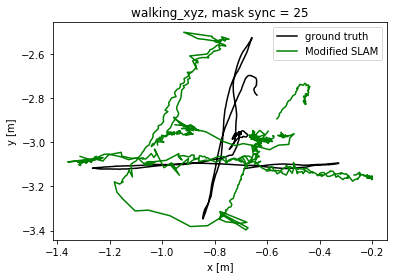

In [103]:
fig = plt.figure()
ax = fig.add_subplot(111)
plot_traj(ax,first_stamps,first_xyz_full.transpose().A,'-',"black","ground truth")
#plot_traj(ax,time_orb,traj_orb.transpose().A,'-',"red","ORB-SLAM2")
plot_traj(ax,time_dyna,traj_dyna.transpose().A,'-',"green","Modified SLAM")


ax.legend()
ax.set_title("walking_xyz, mask sync = {}".format(skip))
ax.set_xlabel('x [m]')
ax.set_ylabel('y [m]')
plt.show()
#plt.savefig(args.plot,dpi=90)

In [104]:
def calc_errors(ground_truth, filename, i_list):
    errors = []
    for i in i_list:
        error, _, _ = calculate_traj(ground_truth, filename.format(i))
        errors.append(error)
    return errors

In [105]:
ground_truth = "/mnt/d/VMware_share/Data/TUM/rgbd_dataset_freiburg3_walking_xyz/groundtruth.txt"
file_name = "/mnt/d/VMware_share/Experiments/trajectories/optical_flow/w_xyz_Dyna_skip{}.txt"
file_name_naive = "/mnt/d/VMware_share/Experiments/trajectories/TUM_rgbd/w_xyz_Dyna_skip{}.txt"

In [117]:
time_dic_naive = {
    2:1.29449,
    3:0.644272,
    4:0.493096,
    5:0.400263,
    6:0.357007,
    7:0.305876,
    8:0.294132,
    9:0.253939,
    10:0.247304,
    11:0.209899,
    12:0.681819,
    13:0.174866,
    14:0.184278,
    15:0.169874,
    16:0.161708,
    17:0.157362,
    18:0.165114,
    19:0.145357,
    20:0.149005,
    21:0.141017,
    22:0.146345,
    23:0.132519,
    24:0.131299,
    25:0.128529,
    26:0.123064,
    27:0.119991,
    28:0.127082,
    29:0.11905,
    30:0.121171,
    31:0.115366,
    32:0.113033,
    33:0.111256,
    34:0.326507,
    35:0.0997906,
    36:0.105995,
    37:0.103728,
    38:0.094925,
    39:0.0973893,
    40:0.0954957,
}
step_list_naive = [2,3,4,5,7,10,11,12,13,14,15,16,17,18,19,20,23,25,27,30,33,35,37,40]

In [118]:
time_dic = {
    2:0.944921,
    3:0.691593,
    4:0.490942,
    5:0.450083,
    6:0.506744,
    7:0.37288,
    8:0.330922,
    9:0.311275,
    10:0.288166,
    11:0.283223,
    12:0.266247,
    13:0.250419,
    14:0.244572,
    15:0.241723,
    16:0.22498,
    17:0.223282,
    18:0.216107,
    19:0.211363,
    20:0.210906,
    21:0.540255,
    22:0.207233,
    23:0.200401,
    24:0.198552,
    25:0.196224,
    26:0.190292,
    27:0.18939,
    28:0.193654,
    29:0.190043,
    30:0.183142,
    31:0.192173,
    32:0.179465,
    33:0.183903,
    34:0.183702,
    35:0.186832,
    36:0.181541,
    37:0.184778,
    38:0.26538,
    39:0.183688,
    40:0.174521,
}
step_list = range(2, 41)

In [127]:
errors = calc_errors(ground_truth, file_name, step_list_naive)

In [128]:
errors_naive = calc_errors(ground_truth, file_name_naive, step_list_naive)

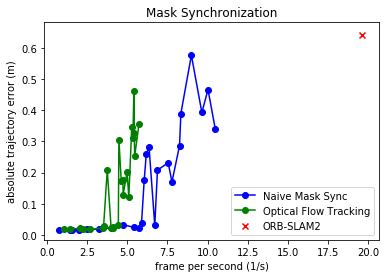

In [129]:
plt.plot(([1/x for x in sorted([time_dic_naive[key] for key in step_list_naive], reverse=True)]), errors_naive, marker="o",color='b', label="Naive Mask Sync")
plt.plot(([1/x for x in sorted([time_dic[key] for key in step_list_naive], reverse=True)]), errors, marker="o",color='g', label="Optical Flow Tracking")
plt.scatter([1/0.051],0.6415, marker='x', color='r', label="ORB-SLAM2")
plt.title("Mask Synchronization")
plt.ylabel("absolute trajectory error (m)")
plt.xlabel("frame per second (1/s)")
plt.legend()
plt.show()

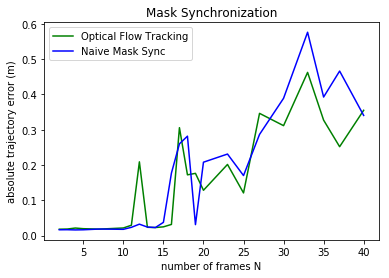

In [130]:
plt.plot(step_list_naive, errors, color='g', label="Optical Flow Tracking")
plt.plot(step_list_naive, errors_naive, color='b', label="Naive Mask Sync")
plt.title("Mask Synchronization")
plt.ylabel("absolute trajectory error (m)")
plt.xlabel("number of frames N")
plt.legend()
plt.show()

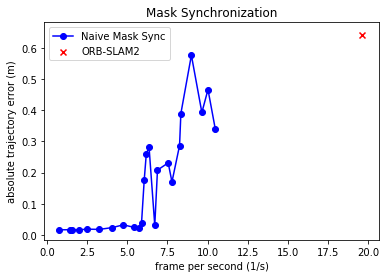

In [131]:
plt.plot(([1/x for x in sorted([time_dic_naive[key] for key in step_list_naive], reverse=True)]), errors_naive, marker="o",color='b', label="Naive Mask Sync")
plt.scatter([1/0.051],0.6415, marker='x', color='r', label="ORB-SLAM2")
plt.title("Mask Synchronization")
plt.ylabel("absolute trajectory error (m)")
plt.xlabel("frame per second (1/s)")
plt.legend()
plt.show()

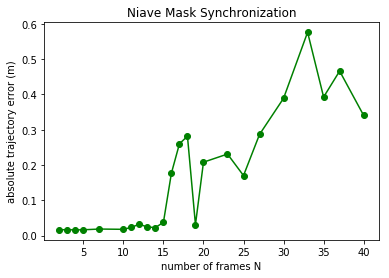

In [133]:
plt.plot(step_list_naive, errors_naive, marker="o",color='g', label="Modified SLAM")
plt.title("Niave Mask Synchronization")
plt.ylabel("absolute trajectory error (m)")
plt.xlabel("number of frames N")
plt.show()

In [ ]:
max(errors)

In [ ]:
import numpy as np
np.median(errors)